# Adaptive Stochastic Gradient Descent

Implementation and comparison of adaptive stochastic gradient descent methods using Python programming language. The efficiency comparison is demonstrated in the logistic regression optimization problem.

## Introduction

**Gradient descent** is one of the most popular numerical methods for solving modern optimization problems: from cost reduction to neural networks training. The thing that all these problems have in common is an aim to describe it as a mathematical model (e.g. mathematical equation) $J(\theta_{i})$, which has a set of independent parameters $\theta_{i}$, and then find specific values of $\theta_{i}$ so $J(\theta_{i})$ will reach the minimum possible value. As an example, in neural network training $J(\theta_{i})$ can be described as a loss between the expected training example and the actual one, where $\theta_{i}$ will be the **weight coefficients** of the neural network. So the goal of the training process is to find the optimal value of **weight coefficients**, so the loss will become minimum and the output value of a neural network will become as close to expected as possible.

By definition, the **gradient** is a vector that points towards the highest  increase of the function value $F$ in high dimensional space $R^{n}$, that can be interpreted as a vector of partial derivatives with respect to each parameter $x_{1}, ..., x_{n}$ of the function $F$ in the specific point $a$:

$\nabla F(a) = \begin{bmatrix}
\frac{\partial f}{\partial x_{1}} (a) \\
\vdots \\
\frac{\partial f}{\partial x_{n}} (a) \\
\end{bmatrix}$

Various optimization algorithms, which are based on **gradient descent**, have common feature: usage of a vector, opposite to the gradient value (antigradient or $- \nabla F$), as the key direction to the function minimum.

### Overviewed algorithms

- SGD
- Dynamic Sampling SGD
- Mini-batch SGD
- Nesterov AG
- ADAGRAD
- RMSPROP
- ADAM

### Tensorflow API usage

**Gradient values** calculation will be speeded up for overviewed methods using [computation graphs](https://www.tensorflow.org/api_docs/python/tf/Graph) from [TensorFlow framework API](https://github.com/tensorflow/tensorflow).

In [1]:
import tensorflow as tf

Tensorflow framework provides class [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape) with a set of methods for required computations: [gradient()](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) and [jacobian()](https://www.tensorflow.org/api_docs/python/tf/GradientTape#jacobian). The following section contains examples of gradient computations:

In [2]:
# Defining the scope of gradient computation. Here all defined variables
# will be registered in Tensorflow calculation graph.
with tf.GradientTape(persistent=True) as grad:
  x, y = (tf.Variable(2.0), tf.Variable(-1.0))

  # Single variable equation
  f = x ** 3 + 2 * x ** 2 + 12 * x + 100

  # Multiple variable equation
  F = x ** 2 + x * y + y ** 2

# f'(x) = 3 * x ** 2 + 4 * x + 12, f'(2.0) = 32.0
df = grad.gradient(f, x)

# dFdx = 2 * x + y, dFdx(2.0, -1.0) = 3.0
# dFdy = x + 2 * y, dFdy(2.0, -1.0) = 0.0
[dFdx, dFdy] = grad.gradient(F, [x, y])

# Release graph allocated memory
del grad

print(f'Single variable equation:\nf\'(2.0) = {df};\n')
print(f'Multiple variable equation:\ndFdx(2.0, -1.0) = {dFdx};\ndFdy(2.0, -1.0) = {dFdy};')

Single variable equation:
f'(2.0) = 32.0;

Multiple variable equation:
dFdx(2.0, -1.0) = 3.0;
dFdy(2.0, -1.0) = 0.0;


### Tensor operations

All tensor-like structure wrappers and operation methods for them are used from [Numpy](https://github.com/numpy/numpy) package.

In [3]:
import numpy as np

### Algorithm convergence visualisation

Iterations of the each **gradient descent** algorithm can be plotted as the path on 3D surface, in case model has only 2 independent parameters $\{ \theta_{1}, \theta_{2} \}$ so they can represent $X$ and $Y$ axises, and remaining $Z$ axis represents value of estimation equation to optimize $J(\theta_{1}, \theta_{2})$. All visualisation tools are used from [matplotlib](https://github.com/matplotlib/matplotlib) package.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as colormaps

Useful plotting functions

In [5]:
from typing import Callable


def plot_grid(F: Callable[[np.array, np.array], np.array],
              X: np.array, Y: np.array,
              elev=30, azim=50, ax=None):
  """
  Plots 3D surface grid for 2 independent
  parameters and estimation equation
  :param F: estimation equation
  :param X: first independent parameter
  :param Y: second independent parameter
  :param elev: vertical rotation angle
  :param azim: horizontal rotation angle
  :param ax: predefined plotting axis
  :return: generated plotting axis
  """

  # Generating grid
  x, y = np.meshgrid(X, Y)

  # If grid plotting axis is not defined above,
  # the new one will be created.
  if ax is None:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(elev=elev, azim=azim)

  # Plotting grid
  surf = ax.plot_surface(x, y, F(x, y), 
                         cmap=colormaps.coolwarm, 
                         antialiased=True)
  fig.colorbar(surf)

  # For axis reusability purposes
  return ax

### Optimization problem

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is chosen as an example of an optimization problem for comparing the convergence rate of the **gradient descent** algorithms. This mathematical model can be described as a binary classifier, which outputs a probability value of a certain set of features $x_{i}$ to belong to a certain class (e. g. **true** or **false**). Using the definition of optimization problem from above, the classifier can be represented in the form of two components: **an adder** that combines all the characteristics into a single one: $z = \sum_{i=1}^{n} \theta_{i} x_{i}$, and **a converter** that calculates the probability of the characteristics belonging to a certain class based on the output value of **an adder**: $g(z) = \frac{1}{1 + e^{z}}$.

## SGD

The following code demonstrates class usage in the optimization problem for the **Rosenbrock function**:

$F(x, y) = (1 - x)^{2} + 100(y - x^{2})^{2}$

Function has a single local minimum in $(x, y) = (1, 1)$ and is equal $F(x, y) = 0$ in the following point.

The gradient value, by definition, is a vector that points towards the direction of the greatest increase of the function. In order to reach a local minimum using an iterative algorithm, the next step should be in the direction opposite to the gradient value. So the full algorithm of finding local minimum can be described as $x_{i+1} = x_{i} - \lambda_{i}\nabla F$, where $\lambda_{i} = const$ - size of a single step, $x_{i}$ - current step.

In [6]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, x: tf.Variable, y: tf.Variable) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, x, y))

    # Optimization function
    F = (1.0 - x) ** 2.0 + 100.0 * (y - x ** 2.0) ** 2.0
    [dF_dx, dF_dy] = grad.gradient(F, [x, y])

  return x - alpha * tf.Variable(dF_dx), y - alpha * tf.Variable(dF_dy)

# Gradient steps
steps = 1000

# Gradient step size
alpha = tf.constant(0.001)

# Start conditions
x = tf.Variable(2.0)
y = tf.Variable(-1.0)

# Iterations
xi_yi = np.array([x.numpy(), y.numpy()])

for _ in range(steps):
  # Iterative descent
  x, y = gradient_step(alpha, x, y)
  xi_yi = np.vstack((xi_yi, np.array([x.numpy(), y.numpy()])))

print(f"Closest approximation of the local minimum: [{xi_yi[steps, 0]}, {xi_yi[steps, 1]}]")

Closest approximation of the local minimum: [0.9669684171676636, 0.9348930716514587]


Visualisation intervals and rendering density

In [7]:
density = 0.1

X = np.arange(-2.0, 2.0, density)
Y = np.arange(-1.0, 3.0, density)

**Rosenbrock function** in vector form:

In [8]:
F = lambda x, y: (1.0 - x) ** 2.0 + 100.0 * (y - x ** 2.0) ** 2.0

Descent visualisation for space $(x, y) \in \{ -2 \leq x \leq 2; -1 \leq y \leq 3 \}$

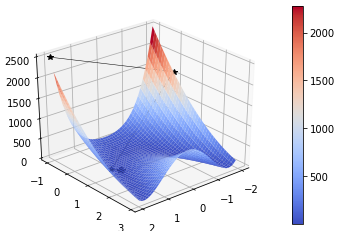

In [9]:
ax = plot_grid(F, X, Y)
ax.plot(xi_yi[:, 0].T, xi_yi[:, 1].T, F(xi_yi[:, 0], xi_yi[:, 1]).T,
        lw=0.5, marker='*', color='black')

plt.show()

## Attribution

Overview is based on research paper "An overview of gradient descent optimization algorithms" from [arXiv.org](https://arxiv.org/pdf/1609.04747.pdf) by [Sebastian Ruder](mailto:ruder.sebastian@gmail.com) licensed under CC BY-NC-SA 4.0.